### RoofLine

"We believe that for the recent past and foreseeable future, off-chip memory bandwidth will often be the constraining resource. Hence, we want a model that relates processor performance to off-chip memory traffic"

This was the cricial insight in 2009. Multicore computing was changing the mix of resources.  It became possible to deliver many more flops (in cores) without at all increasing the off-core bandwdith.
 
#### Concepts

The total number of $\mbox{FLOPS}/s$ realized is bounded by either:
  * the amount of data delivered to the processor times the operational intensity $(\mbox{GB}/s \cdot \mbox{FLOPS}/\mbox{GB})$
  * the peak processing throughput of the processor
  
Operational intensity is a measure of how many times you use each byte.  Graphically, these bounds look like:

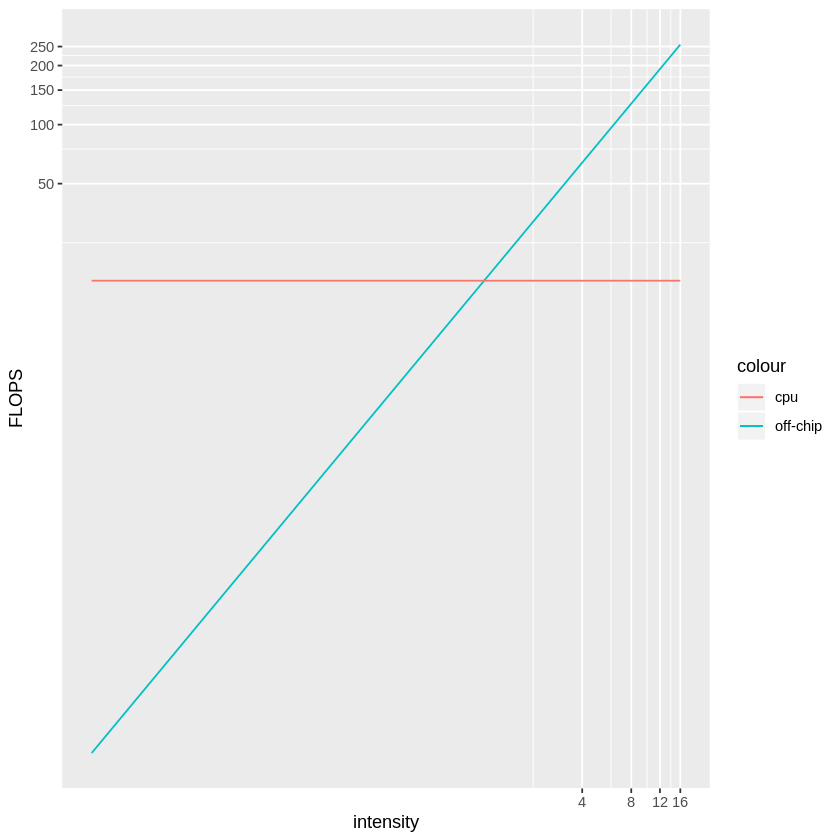

In [1]:
library(ggplot2)

intensity = 2^(-8:4)

offchip = 16 # GB/s
flopsmax = 16 # GFLOPs
        
memband <- data.frame(intensity, intensity * 16, flopsmax )
colnames(memband) <- c("intensity", "FLOPS", 'cpuFLOPS')

 
       
aplot <- ggplot(memband, aes(x=intensity, y=FLOPS, color="off-chip")) + geom_line() +
            geom_line(data=memband, aes(x=intensity, y=cpuFLOPS, color="cpu")) +
            coord_trans(x="log2", y="log2") #+ scale_y_continuous(limits=c(1,50))

print(aplot)


* `off-chip` BW is the amount of data transferred from DRAM to the processor

Taking the minimum of these functions describes the __roofline__.  This is the 
feasible region for a computation:
  * no possible program can exceed the roofline
  * inefficiencies in programs may be less than the roofline

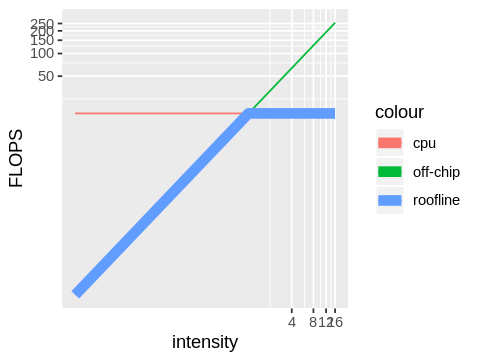

In [4]:
library(ggplot2)
library(repr)
options(repr.plot.width=4, repr.plot.height=3)

intensity = 2^(-8:4)
offchip = 16 # GB/s
flopsmax = 16 # GFLOPs
        
memband <- data.frame(intensity, intensity * 16, flopsmax, pmin(intensity*16,flopsmax) )
colnames(memband) <- c("intensity", "FLOPS", 'cpuFLOPS', 'Roofline')
       
aplot <- ggplot(memband, aes(x=intensity, y=FLOPS, color="off-chip")) + geom_line() +
            geom_line(data=memband, aes(x=intensity, y=cpuFLOPS, color="cpu")) +
            geom_line(data=memband, aes(x=intensity, y=Roofline, color="roofline"), size=3) +
            coord_trans(x="log2", y="log2") #+ scale_y_continuous(limits=c(1,50))
print(aplot)

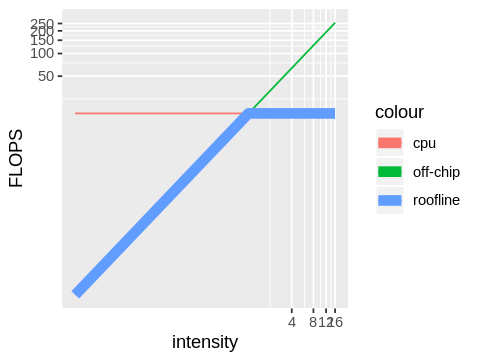

In [3]:
intensity = 2^(-8:4)
offchip = 16 # GB/s
flopsmax = 16 # GFLOPs
        
memband <- data.frame(intensity, intensity * 16, flopsmax, pmin(intensity*16,flopsmax) )
colnames(memband) <- c("intensity", "FLOPS", 'cpuFLOPS', 'Roofline')
       
aplot <- ggplot(memband, aes(x=intensity, y=FLOPS, color="off-chip")) + geom_line() +
            geom_line(data=memband, aes(x=intensity, y=cpuFLOPS, color="cpu")) +
            geom_line(data=memband, aes(x=intensity, y=Roofline, color="roofline"), size=3) +
            coord_trans(x="log2", y="log2") #+ scale_y_continuous(limits=c(1,50))
print(aplot)

#### Kernels

So, the idea is to measure a given programs operational intensity, which will correspond to a vertical line on the plot.  The peak of the roofline divides the world into:
  1. memory-bound or 
  2. CPU bound

<img src="./images/roofline.png" width=512 />

#### Effect of Mulitcore

Multicore processing has only made the situation worse.  The paper gives the example in which Intel added two cores and increased CPU speed without changing the socket.
  * All memory bound programs perform the same
  * Some CPU bound programs become memory bound and realize only partial speedup (intensities 1.5-8)
  * Only the most dense programs see benefit
  
Overtime, processors grow faster than memories and all kernels become memory bound!!!!
  * This has happened progressively.

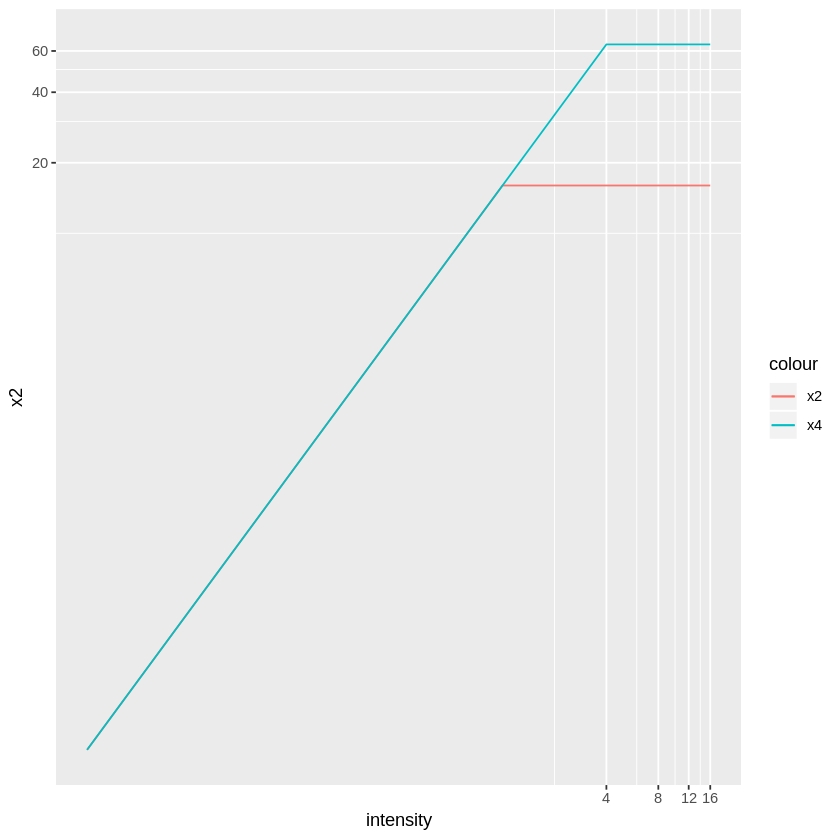

In [1]:
library(ggplot2)

intensity = 2^(-8:4)

offchip = 16 # GB/s
flopsmax = 16 # GFLOPs
flopsmax2 = 64
        
memband <- data.frame(intensity, pmin(intensity*16,flopsmax), pmin(intensity*16,flopsmax2) )
colnames(memband) <- c("intensity", "x2", 'x4')
       
aplot <- ggplot(memband, aes(x=intensity, y=x2, color="x2")) + geom_line() +
            geom_line(data=memband, aes(x=intensity, y=x4, color="x4")) +
             coord_trans(x="log2", y="log2") #+ scale_y_continuous(limits=c(1,50))
           # coord_trans(x="log2") #+ scale_y_continuous(limits=c(1,50))


print(aplot)

### Using Roofline to Optimize Code

* Enhance CPU performance to raise peak.
  * unroll loops (increase compute density)
  * SIMD (vector instructions)
* Improve data movement to shift memory bound
  * sequential data access 
  * coherent data access
  * software prefetching

These are all pretty low-level, but exactly the same optimization trajectory as we used for OpenMP.

<img src="./images/roofline2.png" width=512 />

Looking at the whole figure, we can see the structure of compute:
  * TLP == thread-level parallelism, use all threads
  * ILP == plus a bunch of stuff that's not well defined.
    * pipelining -- isn't that already part of FLOPs measure
    * branch prediction
    * functional unit latency
  * SIMD -- we know what this is.  vectorize computation
  * multiply/add balance -- processor do fused multiple adds (ax + b) in a single instruction when possible.
 
So, there are sub-rooflines that reveal structure that associate code performance with optimization.
  


### Kernel Again

The authors picked 7 typical data-science/science codes and mapped their kernels.

<img src="./images/roofline3.png" width=512 />

Observations:
  * These are well optimized -- the code performance lies near the roofline.
  * None of these codes has the operational intensity needed to reach peak 
  
It is reasonable to conclude that we are designing processors incorrectly.  More attention should be paid to off-chip bandwidth.
  * You could eliminate a bunch of processing power (by core count or clock rate) and produce a lower-power chip that runs exactly as well.
  * This is 2009.  The situation has only gotten worse.  Roofline peaks go up and to the right.
 

### Relationship with GPU and ML

The goal of GPU optimization has always been to maximize memory bandwidth.
  * this assumes that you live in the memory bound domain
  * this has been largely true for scientific codes.
  * Operational intensity of <20
  
Training ML models has crazy operational intensity. >100
  * Google made a compelling case for this in their TPU paper.
  * TPU has a peak at ~1000.
